In [1]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
from tensorflow import keras
import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
import os
import fnmatch
import pandas as pd
import bezier

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


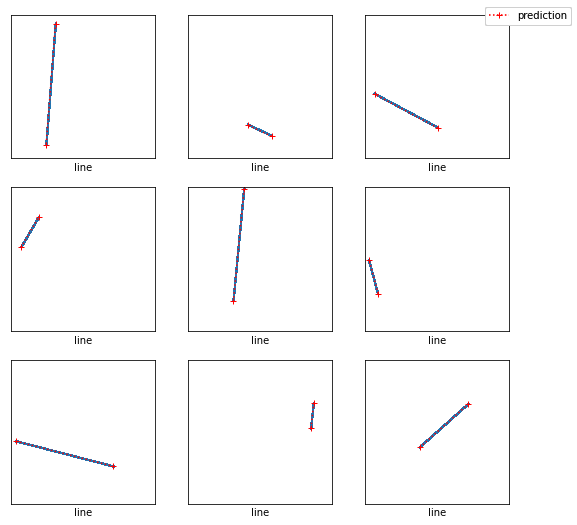

In [2]:
plt.figure(figsize=(9, 9))

image_root = './images/train/'
image_labels = ['line']

total_files = fnmatch.filter(os.listdir(image_root), '*.png')
df=pd.read_csv('./images/train.csv', sep=',',header=0)

def image_read(fn):
    link = os.path.join(image_root, fn)
    image = Image.open(link).convert('RGB')
    im = np.asarray(image)
    #print(im.shape)
    return im
    
def getInfo(idx):
    image = image_read(df.filename[idx])
    class_id = 0 #df.class[idx]
    xmin = df.xmin[idx]
    xmax = df.xmax[idx]
    ymin = df.ymin[idx]
    ymax = df.ymax[idx]
    return image, class_id, [xmin, ymin], [xmax, ymax]

def generate_bezier(x, y):
    nr = np.asarray(x, y)
    curve = bezier.Curve(nr, degree=1)
    
    return curve

def gen_plots():
    for i in range(9):
        rand_idx = randint(0, len(total_files))
        image, class_id, x, y = getInfo(rand_idx)
        ax = plt.subplot(3, 3, i+1)
        
        l1 = ax.imshow(image, extent=[0, 144, 0, 144])
        l1.set_label("")
        
        # Create bezier curve or plot a line
        '''
        curve = generate_bezier(x, y)
        g_truth = curve.plot(num_pts=256, color="r", ax=ax)
        g_truth.lines[-1].set_label('prediction var 1')
        g_truth.lines[-1].set_linestyle('dotted')
        g_truth.lines[-1].set_marker('+')
        g_truth.lines[-1].set_markersize(2)
        '''
        
        ax.plot(x, y, 'r+', linestyle='dotted', label='prediction')
        
        lines, labels = ax.get_legend_handles_labels()
        plt.legend( lines, labels, loc = 'best', bbox_to_anchor = (0,-0.1,1,1),
                    bbox_transform = plt.gcf().transFigure )
        
        plt.xlabel(image_labels[0])
        plt.xticks([])
        plt.yticks([])

gen_plots()

# PLOT LINE

In [3]:
def tester():
    rand_idx = randint(0, len(total_files))
    image, class_id, x, y = getInfo(rand_idx)
    return image

def plot_line(image, pred_coords=[], norm=False):

  figo = Figure(figsize=(2, 2))

  canvas = FigureCanvasAgg(figo)

  # plot
  ax_r = figo.add_subplot()
  if norm:
        image *= 255.
        image = image.astype(np.uint8)
  ax_r.imshow(image, extent=[0,144,0,144])

  if len(pred_coords) == 2:
      x, y = pred_coords
      #print(x, y)
      xmin = x[0]
      xmax = x[1]
      ymin = y[0]
      ymax = y[1]
      ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    
  ax_r.set_axis_off()

  canvas.draw()
  
  buf = canvas.buffer_rgba()
  # ... convert to a NumPy array ...
  X = np.asarray(buf)
  # ... and pass it to PIL.
  im = Image.fromarray(X)
  
  return im

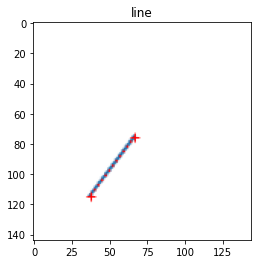

In [4]:
rand_idx = randint(0, len(total_files))
image, class_id, x, y = getInfo(rand_idx)
image = plot_line(image, pred_coords=[x, y])
plt.imshow(image)
plt.title("line")
plt.show()

# DATA GEN

In [5]:
#shape 144x144
batch_size = len(total_files)
def data_generator(batch_size=batch_size):
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))
    y_batch = np.zeros((batch_size, 1))
    bline_batch = np.zeros((batch_size, 4))

    for i in range(0, batch_size):
      rand_idx = randint(0, len(total_files))
      image, class_id, x, y = getInfo(rand_idx)
      x_batch[i] = image / 255.
      y_batch[i, class_id] = 1.0
      bline_batch[i] = np.array([x[0], x[1], y[0], y[1]])
    yield ({'image': x_batch}, {'class_out': y_batch, 'box_out': bline_batch})

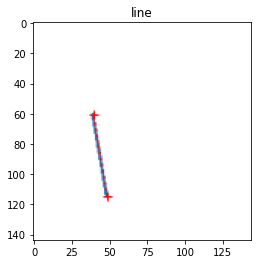

In [6]:
index = 0
example, label = next(data_generator(1))
image = example['image'][index]
class_id = np.argmax(label['class_out'][index])
pred_coords = label['box_out'][index]

x = [pred_coords[0], pred_coords[1]]
y = [pred_coords[2], pred_coords[3]]

image = plot_line(image, pred_coords=[x, y], norm=True)

plt.imshow(image)
plt.title('line')
plt.show()

# MODEL

In [8]:
def model2():
    h = w = 144
    
    backbone             = keras.applications.MobileNet(include_top=False, pooling='avg')
    classification_layer = keras.layers.Dense(1, activation='softmax', name='class_out')
    regression_layer     = keras.layers.Dense(4, name='box_out')

    x = x0   = keras.Input(shape=(None,None,3), name='image')
    x        = backbone(x)
    x1        = classification_layer(x)
    x2        = regression_layer(x)
    model    = keras.Model(inputs=x0, outputs=[x1, x2])
    
    return model

In [10]:

model = model2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Functional) (None, 1024)         3228864     image[0][0]                      
__________________________________________________________________________________________________
class_out (Dense)               (None, 1)            1025        mobilenet_1.00_224[0][0]         
__________________________________________________________________________________________________
box_out (Dense)                 (None, 4)            4100        mobilenet_1.00_224[0][0]         
Total params: 3,233,989
Trainable params: 3,212,101
Non-trainable params: 21,888
_____________

In [11]:

_metrics = ['tf.keras.metrics.RootMeanSquaredError()', '']
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': [tf.keras.metrics.MeanSquaredError()]
    }
)

In [12]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out'][0]   

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  xc = [pred_coords[0], pred_coords[1]]
  yc = [pred_coords[2], pred_coords[3]]

  #print(xc, yc)

  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = "line"
  pred_class_name = "line"
  
  box = [[box[0], box[1]], [box[2], box[3]]]

  image = plot_line(image, pred_coords=[xc, yc], norm=True)
  color = 'green' if gt == pred_class_name else 'red'

  plt.imshow(image)
  #plt.show()
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [13]:
def test(model):
  test_datagen = data_generator(1)
  plt.figure(figsize=(16, 4))

  for i in range(0, 6):
    plt.subplot(1, 6, i + 1)
    test_model(model, test_datagen)
  plt.show()

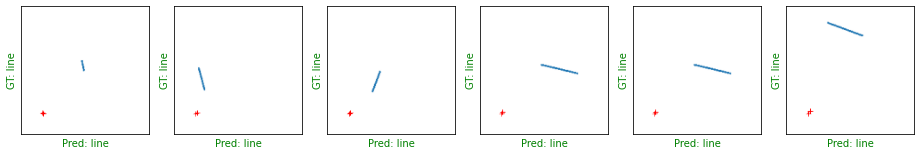

In [14]:
test(model)

In [15]:

class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

# Model Training

Epoch 1/50
500/500 [==============================] - 635s 1s/step - loss: 414.2424 - class_out_loss: 0.0000e+00 - box_out_loss: 414.2424 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 414.2424


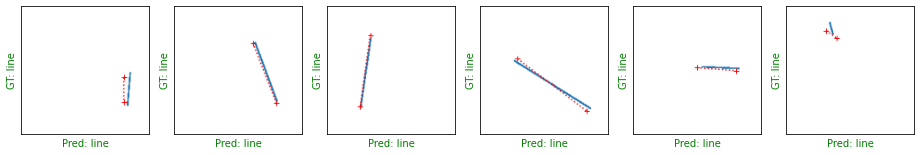

Epoch 2/50
500/500 [==============================] - 601s 1s/step - loss: 4.2824 - class_out_loss: 0.0000e+00 - box_out_loss: 4.2824 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 4.2824


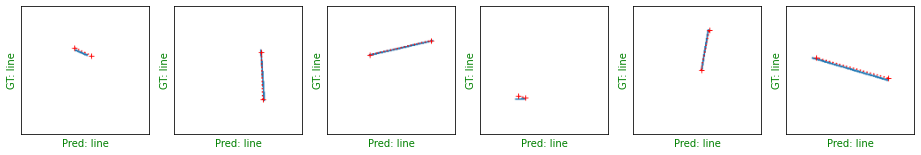

Epoch 3/50
500/500 [==============================] - 600s 1s/step - loss: 2.4730 - class_out_loss: 0.0000e+00 - box_out_loss: 2.4730 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 2.4730


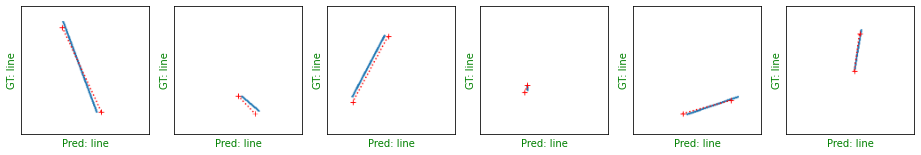

Epoch 4/50
500/500 [==============================] - 599s 1s/step - loss: 1.4967 - class_out_loss: 0.0000e+00 - box_out_loss: 1.4967 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 1.4967


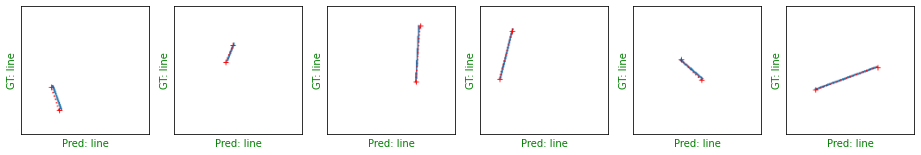

Epoch 5/50
500/500 [==============================] - 602s 1s/step - loss: 0.7376 - class_out_loss: 0.0000e+00 - box_out_loss: 0.7376 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.7376


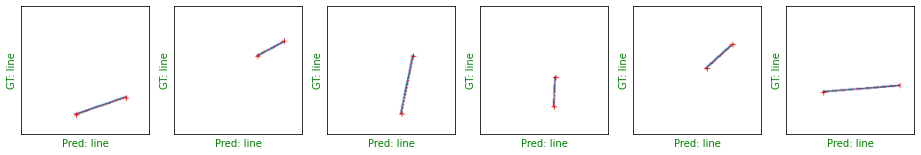

Epoch 6/50
500/500 [==============================] - 602s 1s/step - loss: 0.6411 - class_out_loss: 0.0000e+00 - box_out_loss: 0.6411 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.6411


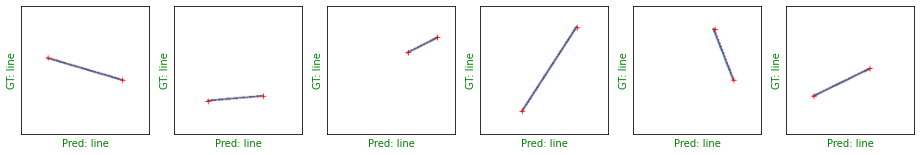

Epoch 7/50
500/500 [==============================] - 601s 1s/step - loss: 0.5667 - class_out_loss: 0.0000e+00 - box_out_loss: 0.5667 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.5667


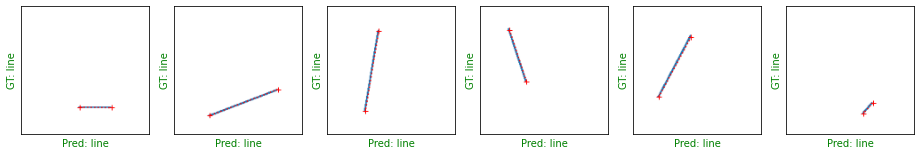

Epoch 8/50
500/500 [==============================] - 602s 1s/step - loss: 0.5279 - class_out_loss: 0.0000e+00 - box_out_loss: 0.5279 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.5279


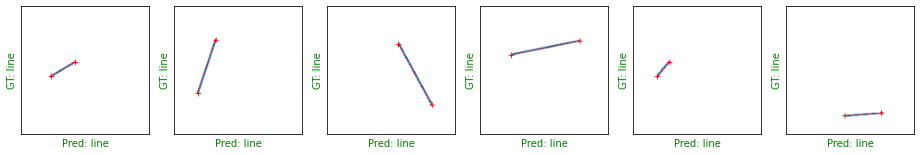

Epoch 9/50
500/500 [==============================] - 605s 1s/step - loss: 0.4976 - class_out_loss: 0.0000e+00 - box_out_loss: 0.4976 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.4976


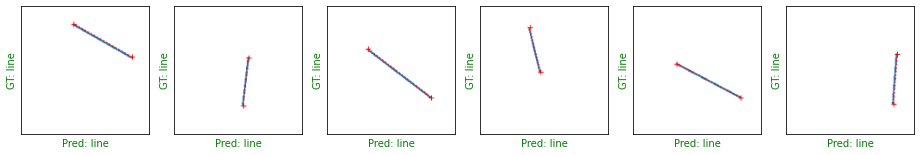

Epoch 10/50
500/500 [==============================] - 603s 1s/step - loss: 0.3369 - class_out_loss: 0.0000e+00 - box_out_loss: 0.3369 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.3369


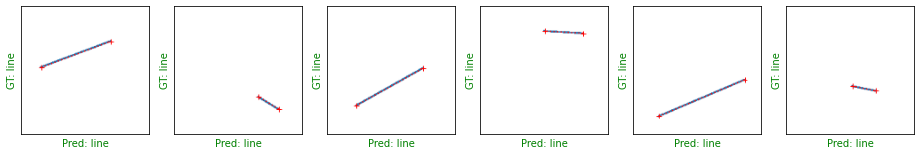

Epoch 11/50
500/500 [==============================] - 602s 1s/step - loss: 0.3102 - class_out_loss: 0.0000e+00 - box_out_loss: 0.3102 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.3102


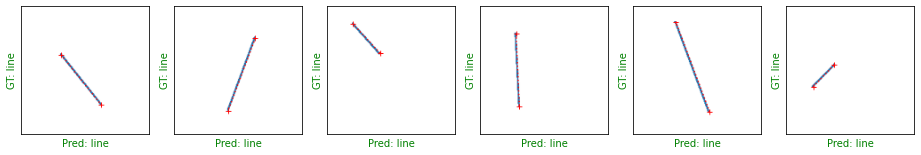

Epoch 12/50
500/500 [==============================] - 608s 1s/step - loss: 0.3095 - class_out_loss: 0.0000e+00 - box_out_loss: 0.3095 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.3095


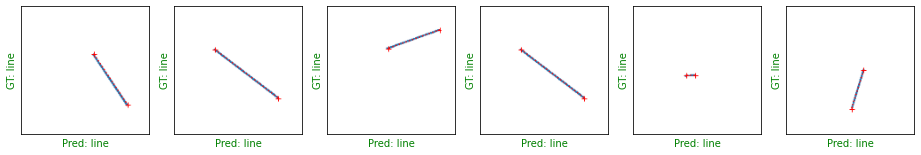

Epoch 13/50
500/500 [==============================] - 608s 1s/step - loss: 0.2956 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2956 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2956


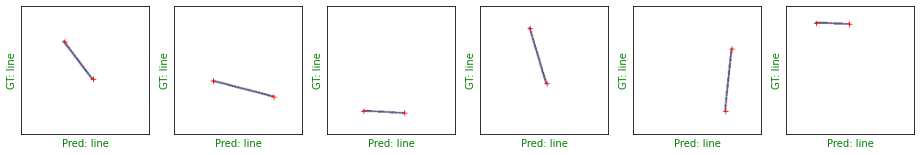

Epoch 14/50
500/500 [==============================] - 605s 1s/step - loss: 0.2699 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2699 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2699


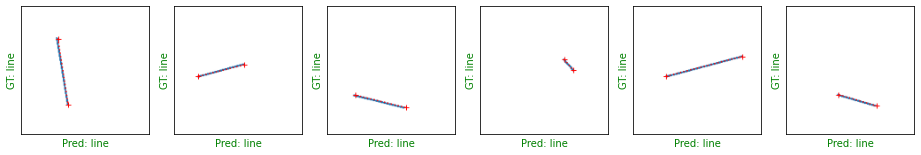

Epoch 15/50
500/500 [==============================] - 604s 1s/step - loss: 0.2403 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2403 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2403


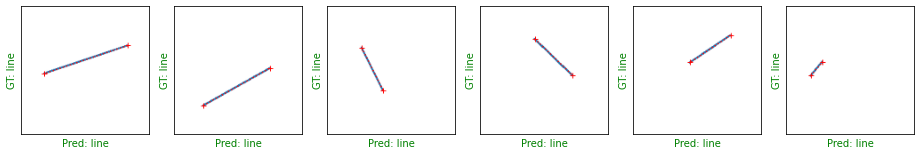

Epoch 16/50
500/500 [==============================] - 601s 1s/step - loss: 0.2583 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2583 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2583


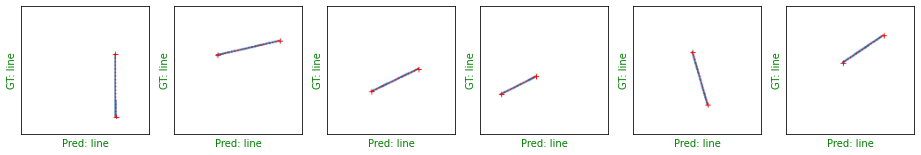

Epoch 17/50
500/500 [==============================] - 607s 1s/step - loss: 0.2600 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2600 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2600


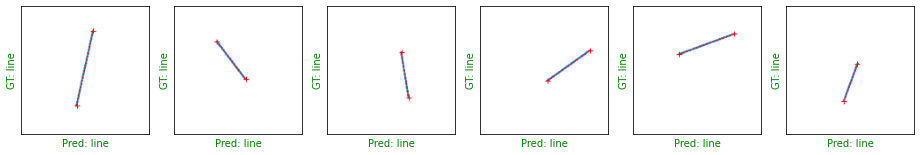

Epoch 18/50
500/500 [==============================] - 604s 1s/step - loss: 0.2435 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2435 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2435


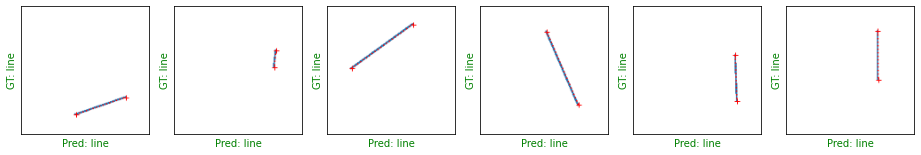

Epoch 19/50
500/500 [==============================] - 607s 1s/step - loss: 0.2286 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2286 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2286


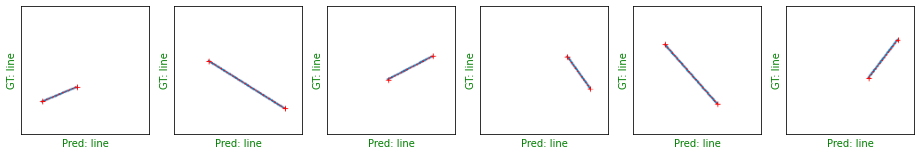

Epoch 20/50
500/500 [==============================] - 603s 1s/step - loss: 0.2299 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2299 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2299


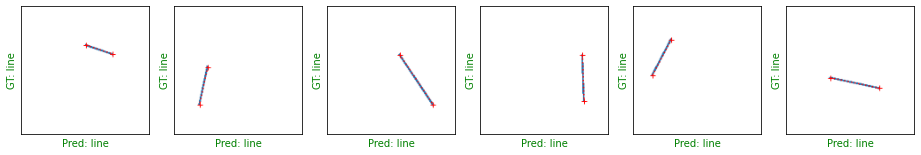

Epoch 21/50
500/500 [==============================] - 602s 1s/step - loss: 0.2142 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2142 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2142


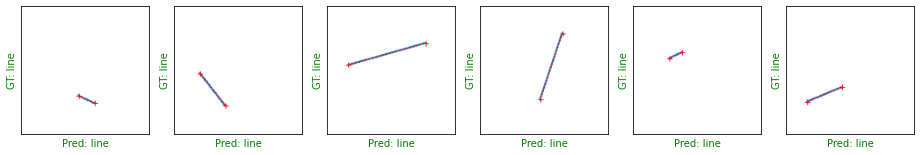

Epoch 22/50
500/500 [==============================] - 604s 1s/step - loss: 0.2195 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2195 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2195


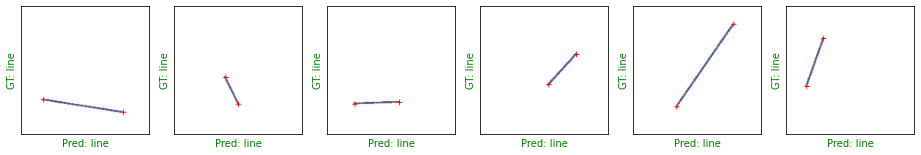

Epoch 23/50
500/500 [==============================] - 603s 1s/step - loss: 0.2400 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2400 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2400


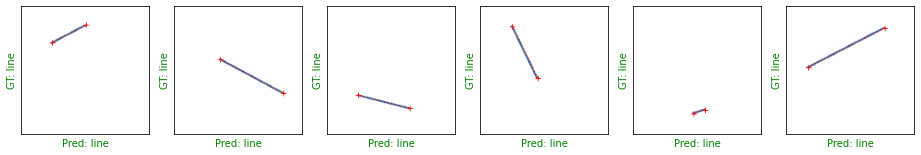

Epoch 24/50
500/500 [==============================] - 602s 1s/step - loss: 0.2255 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2255 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2255


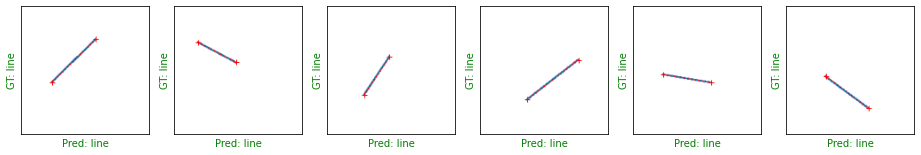

Epoch 25/50
500/500 [==============================] - 605s 1s/step - loss: 0.2172 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2172 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2172


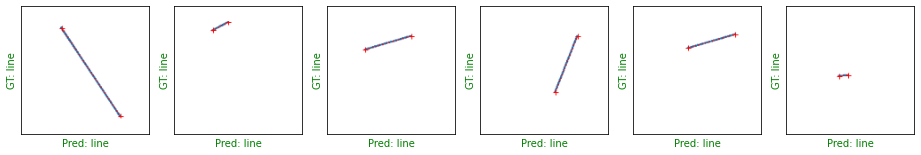

Epoch 26/50
500/500 [==============================] - 597s 1s/step - loss: 0.2240 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2240 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2240


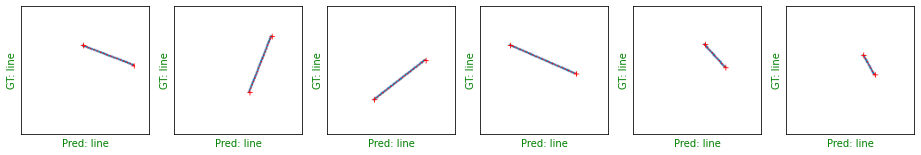

Epoch 27/50
500/500 [==============================] - 604s 1s/step - loss: 0.2084 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2084 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2084


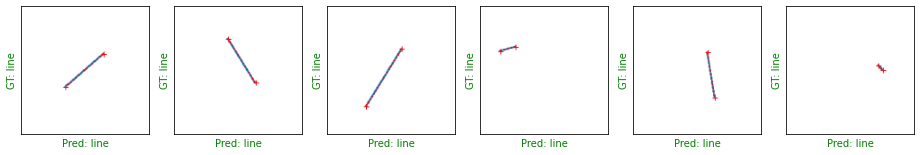

Epoch 28/50
500/500 [==============================] - 602s 1s/step - loss: 0.2307 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2307 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2307


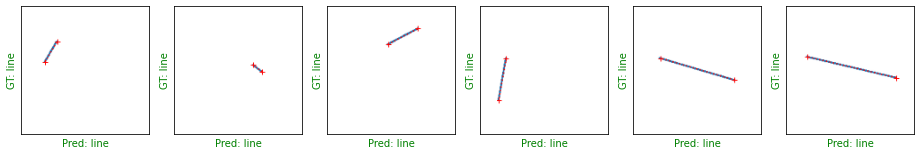

Epoch 29/50
500/500 [==============================] - 602s 1s/step - loss: 0.2027 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2027 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2027


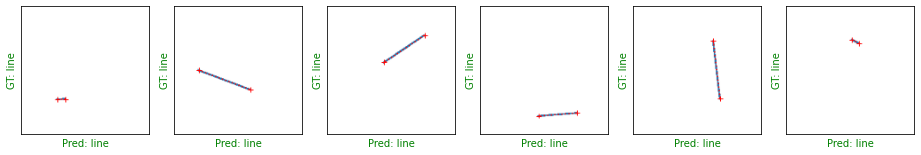

Epoch 30/50
500/500 [==============================] - 604s 1s/step - loss: 0.2278 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2278 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2278


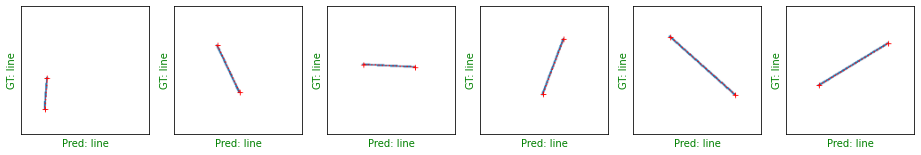

Epoch 31/50
500/500 [==============================] - 596s 1s/step - loss: 0.2127 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2127 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2127


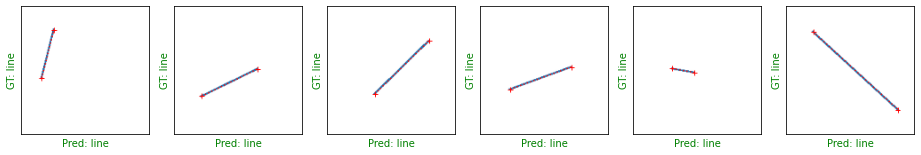

Epoch 32/50
500/500 [==============================] - 604s 1s/step - loss: 0.2104 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2104 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2104


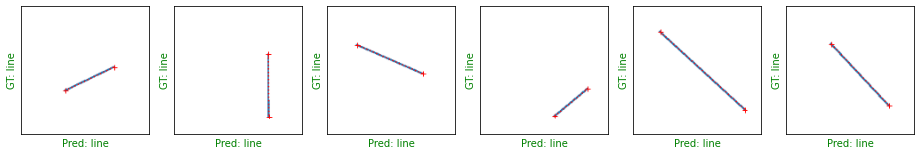

Epoch 33/50
500/500 [==============================] - 601s 1s/step - loss: 0.2283 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2283 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2283


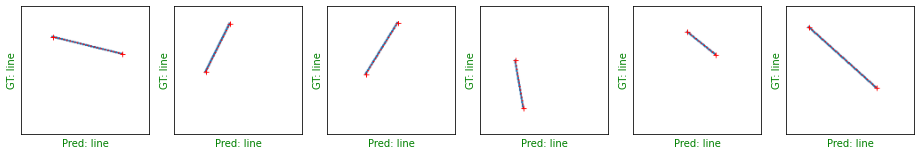

Epoch 34/50
500/500 [==============================] - 607s 1s/step - loss: 0.2204 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2204 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2204


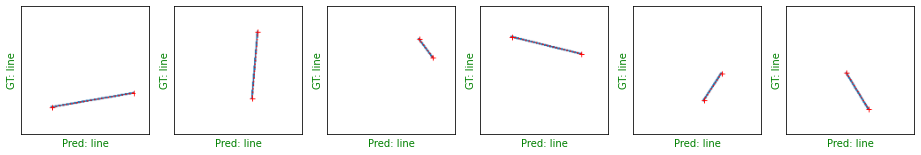

Epoch 35/50
500/500 [==============================] - 606s 1s/step - loss: 0.2092 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2092 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2092


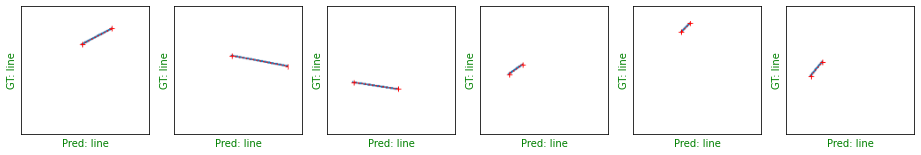

Epoch 36/50
500/500 [==============================] - 595s 1s/step - loss: 0.2136 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2136 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2136


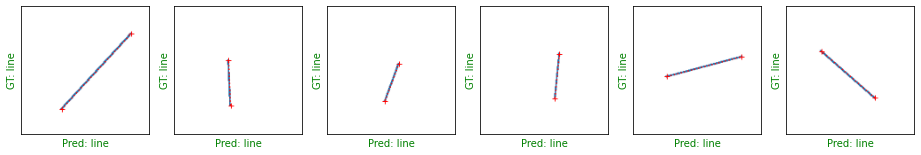

Epoch 37/50
500/500 [==============================] - 603s 1s/step - loss: 0.2045 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2045 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2045


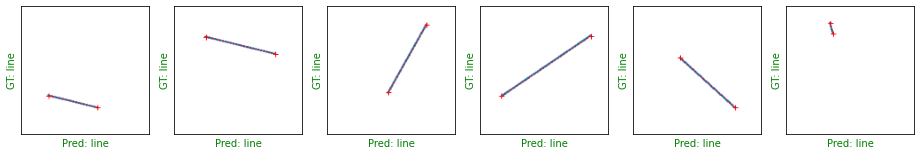

Epoch 38/50
500/500 [==============================] - 604s 1s/step - loss: 0.2171 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2171 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2171


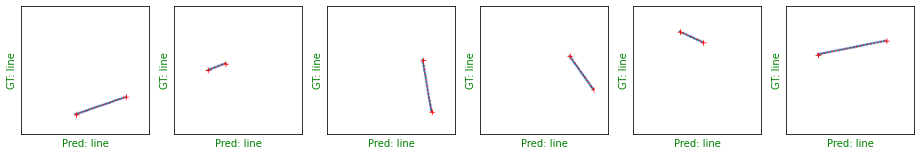

Epoch 39/50
500/500 [==============================] - 604s 1s/step - loss: 0.2055 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2055 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2055


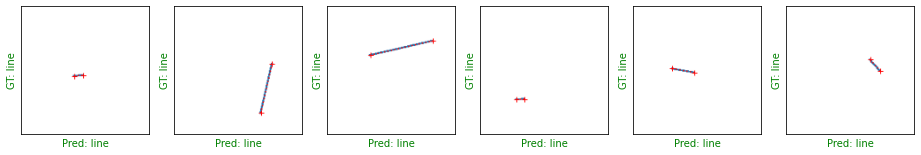

Epoch 40/50
500/500 [==============================] - 604s 1s/step - loss: 0.2216 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2216 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2216


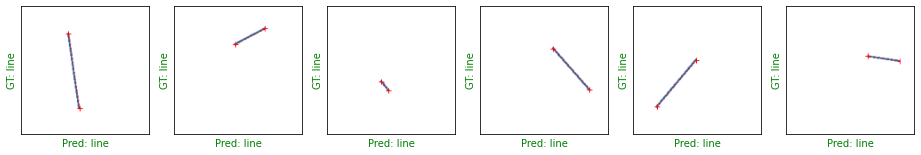

Epoch 41/50
500/500 [==============================] - 602s 1s/step - loss: 0.2189 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2189 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2189


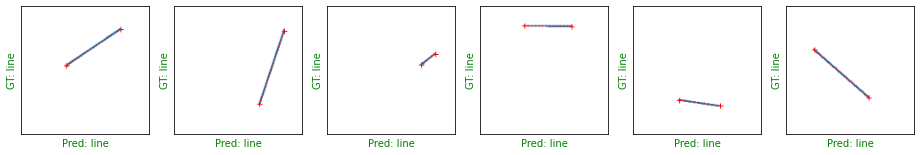

Epoch 42/50
500/500 [==============================] - 606s 1s/step - loss: 0.2205 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2205 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2205


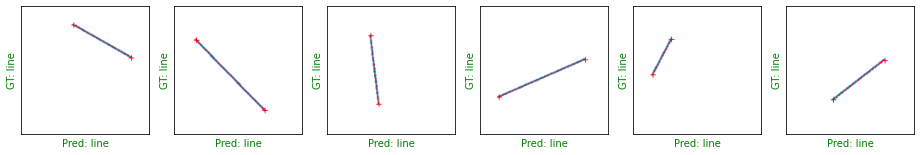

Epoch 43/50
500/500 [==============================] - 600s 1s/step - loss: 0.2132 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2132 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2132


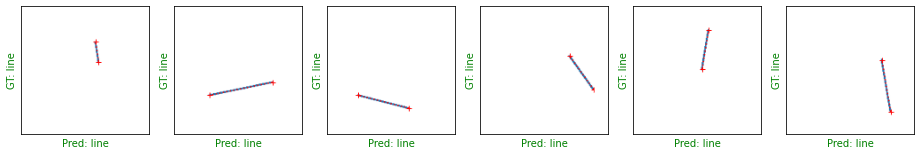

Epoch 44/50
500/500 [==============================] - 603s 1s/step - loss: 0.2144 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2144 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2144


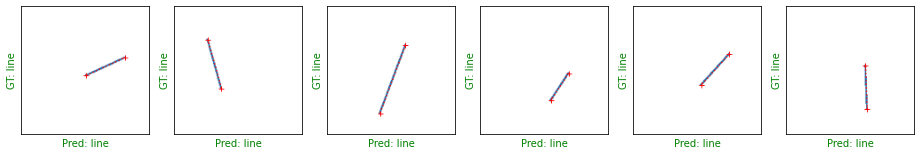

Epoch 45/50
500/500 [==============================] - 603s 1s/step - loss: 0.2265 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2265 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2265


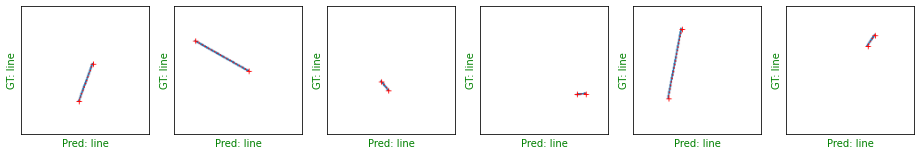

Epoch 46/50
500/500 [==============================] - 605s 1s/step - loss: 0.2171 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2171 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2171


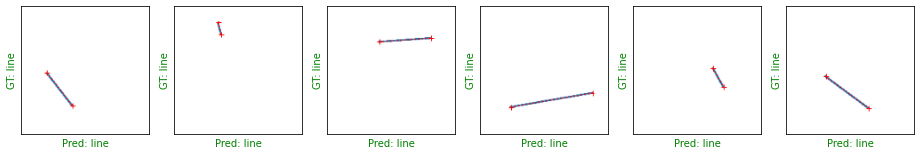

Epoch 47/50
500/500 [==============================] - 601s 1s/step - loss: 0.2052 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2052 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2052


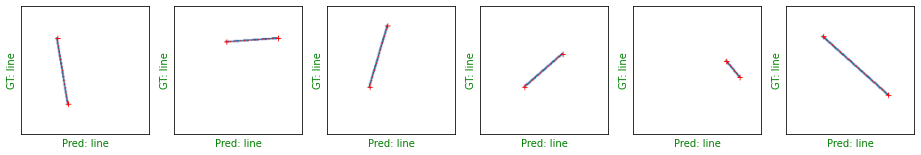

Epoch 48/50
500/500 [==============================] - 604s 1s/step - loss: 0.2053 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2053 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2053


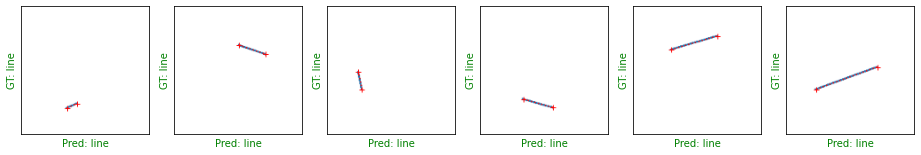

Epoch 49/50
500/500 [==============================] - 601s 1s/step - loss: 0.2103 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2103 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2103


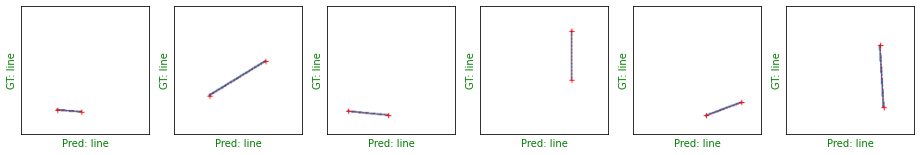

Epoch 50/50
500/500 [==============================] - 604s 1s/step - loss: 0.2107 - class_out_loss: 0.0000e+00 - box_out_loss: 0.2107 - class_out_accuracy: 1.0000 - box_out_mean_squared_error: 0.2107


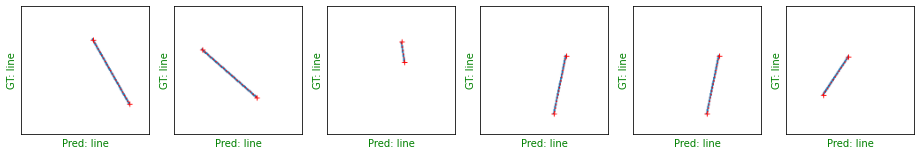

In [17]:

def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)


_ = model.fit(
    data_generator(batch_size=300),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_mean_squared_error', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)